# A Q-Learning Reinforcement Agent in A Grid World

This is a simple example of a Q-Learning agent. Instead of using a table for the 
Q function, here we use a 1-layer perceptron (linear model) to approximate the Q function.

todo: explain the algorithm

In [1]:
import numpy as np
import random
import gym
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

from IPython.display import clear_output
from tqdm import tqdm

In [2]:
env = gym.make('FrozenLake-v0')

[2017-03-20 15:23:39,414] Making new env: FrozenLake-v0


In [3]:
tf.reset_default_graph()

# Use minibatch of 1 for all tensor def.
state = tf.placeholder(shape=[1, 16], dtype=tf.float32)

W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))

Q_out = tf.matmul(state, W)
action = tf.argmax(Q_out, 1)

# Here are the losses
Q_next = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(Q_next - Q_out))

trainer = tf.train.GradientDescentOptimizer(learning_rate = 0.1)
updateModel = trainer.minimize(loss)

In [4]:
def state_hot_enc(s):
    return np.identity(16)[s:s+1]

In [5]:
init = tf.global_variables_initializer()

# Set learning parameters

y = .99
e = 0.1
num_episodes = 2000

# create lists to contain total rewawrds and steps per episode

epi_length = []
rs = []

with tf.Session() as sess:
    sess.run(init)
    for i in tqdm(range(num_episodes)):
        s = env.reset()
        r_total = 0
        done = False
        number_jumps = 0
        
        # limit numerb of jumps
        while number_jumps < 99:
            number_jumps += 1
            
            Q_value, a_value = \
               sess.run([Q_out, action], feed_dict={state:state_hot_enc(s)})
            #print(action, a_value)
            
            
            # pick a random action
            if np.random.rand(1) < e:
                # actual result is the first item in the mini batch
                a_value[0] = env.action_space.sample()
            #print(a_value[0])
            s_next, r, done, _ = env.step(a_value[0])
            #print(s_next, r, d)
            
            
            Q_next_value = sess.run(Q_out, feed_dict={state:state_hot_enc(s_next)})
            
            
            max_Q_next = np.max(Q_next_value)
            
            # now update Q
            Q_value[0, a_value[0]] = r + y * max_Q_next
            
            _, W_value = sess.run([updateModel, W], feed_dict={
                state:state_hot_enc(s), Q_next: Q_value})
 
            r_total += r
            s = s_next
            if done:
                # be more conservative as we learn more
                e = 1./((i/50) + 10)
                break
        # Do not plot
        
        #clear_output(wait=True)
        #plt.plot(Q_next_value[0], 's-')
        #plt.show()
            
        epi_length.append(number_jumps)
        rs.append(r_total)
        
        
        
print("success rate: " + str(sum(rs)/num_episodes) + "%")

100%|██████████| 2000/2000 [00:34<00:00, 58.76it/s]

success rate: 0.495%


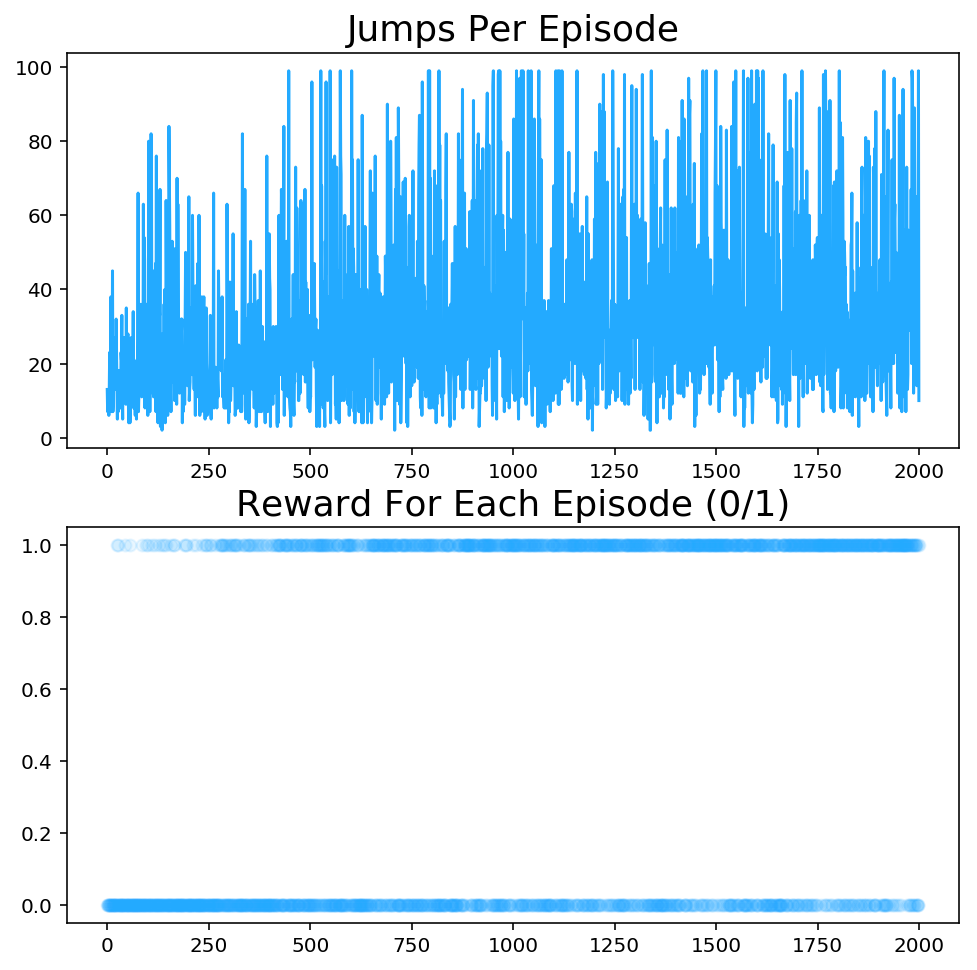

In [6]:
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.title("Jumps Per Episode", fontsize=18)
plt.plot(epi_length, "#23aaff")
plt.subplot(212)
plt.title('Reward For Each Episode (0/1)', fontsize=18)
plt.plot(rs, "o", color='#23aaff', alpha=0.1)
plt.savefig('./figures/Frozen-Lake-v0-tf.png', dpi=300)